<a href="https://colab.research.google.com/github/CUOTR/Credit_Rating_Performance_Python_Project/blob/main/Credit_Rating_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PYTHON: CREDIT RATING PERFORMANCE**


**PYTHON: HIỆU SUẤT ĐÁNH GIÁ TÍN DỤNG**


# **Overview**

This project analyzes a  consumer loan dataset from KAGGLE  to evaluate the performance of the internal credit rating system (`sub_grade`).

The main objective is to assess whether the rating grades (from A1 to G5) effectively discriminate credit risk by examining actual

(`default rates`)(Charged Off loans) across different grades.

# **TỔNG QUAN**

Dự án này phân tích bộ dữ liệu cho vay tiêu dùng từ KAGGLE để đánh giá hiệu quả hoạt động của hệ thống xếp hạng tín dụng nội bộ (sub_grade).

Mục tiêu chính là đánh giá xem các bậc xếp hạng (từ A1 đến G5) có phân biệt rủi ro tín dụng một cách hiệu quả hay không bằng cách xem xét tỷ lệ vỡ nợ thực tế (các khoản vay bị xóa sổ) ở các bậc khác nhau.

# I. EXTRACT, TRANSFORM, LOAD (ETL)


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("/content/CREDIT_RATING.csv")

print(df.isnull().sum())
print(df.describe())
print(df.info())

id                        0
address_state             0
emp_length                0
emp_title              1087
home_ownership            0
loan_status               0
member_id                 0
purpose                   0
sub_grade                 0
term                      0
verification_status       0
annual_income             0
dti                       0
installment               0
int_rate                  0
loan_amount               0
total_acc                 0
total_payment             0
dtype: int64
                 id     member_id  annual_income           dti   installment  \
count  3.196300e+04  3.196300e+04   3.196300e+04  31963.000000  31963.000000   
mean   7.337336e+05  9.201666e+05   7.012571e+04      0.135312    329.247058   
std    1.858260e+05  2.211054e+05   6.488187e+04      0.066511    210.883700   
min    5.724500e+04  7.069900e+04   4.080000e+03      0.000000     16.250000   
25%    5.843730e+05  7.504905e+05   4.200000e+04      0.084400    169.780000   
50%

In [71]:
cols = ['annual_income', 'dti', 'loan_amount', 'installment']

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

print(":", len(df))

df_clean = df.copy()
for col in cols:
    df_clean = remove_outliers(df_clean, col)

print("Số khoản vay sau khi loại outlier:", len(df_clean))
print("Đã loại bỏ:", len(df) - len(df_clean), "khoản vay nghi là outlier")

df = df_clean

: 31963
Số khoản vay sau khi loại outlier: 28817
Đã loại bỏ: 3146 khoản vay nghi là outlier


In [72]:
df.drop(columns=['emp_title'], inplace=True)

df['loan_term'] = df['term'].str.extract(r'(\d+)').astype(float).astype(int)

df['grade'] = df['sub_grade'].str[0]

df.drop(columns=['term'], inplace=True)
df.head(1)

,id,address_state,emp_length,home_ownership,loan_status,member_id,purpose,sub_grade,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment,loan_term,grade
0,1068350,IL,10+ years,MORTGAGE,Fully Paid,1302971,car,A1,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835,36,A


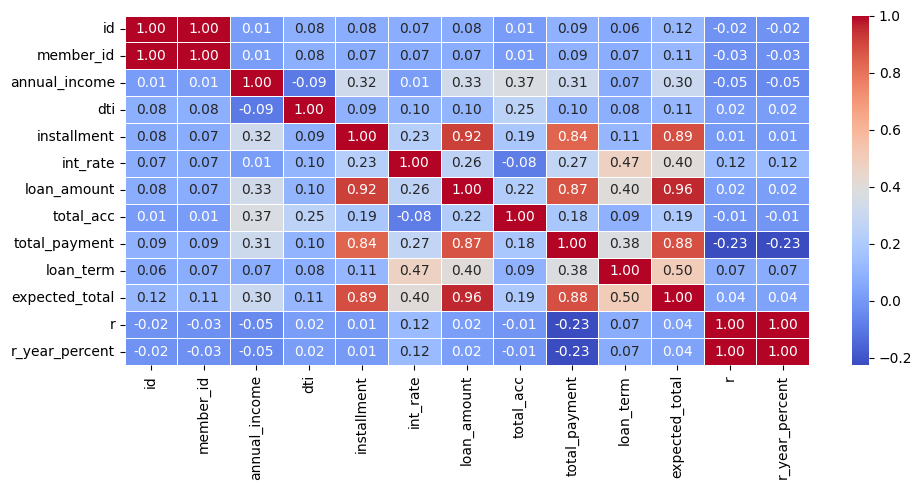

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.show()


# II. EXPLORATORY DATA ANALYSIS (EDA)

1. DEFAULT LOANS

In [85]:
df['expected_total'] = df['loan_term'] * df['installment']

completed_loans = df[df['loan_status'] != 'Current']

total_expected_completed = completed_loans['expected_total'].sum()
total_actual_completed = completed_loans['total_payment'].sum()
total_loss_completed = total_expected_completed - total_actual_completed
loss_rate_completed = total_loss_completed / total_expected_completed

charged_off = df[df['loan_status'] == 'Charged Off']

total_expected_co = charged_off['expected_total'].sum()
total_actual_co = charged_off['total_payment'].sum()
total_loss_co = total_expected_co - total_actual_co
lgd = total_loss_co / total_expected_co

pd_rate = len(charged_off) / len(completed_loans)

print("Loan status distribution:")
print(df['loan_status'].value_counts())

print("\n=== On completed loans (Fully Paid + Charged Off) ===")
print(f"Total expected payment: {total_expected_completed:,.2f} USD")
print(f"Total actual payment received: {total_actual_completed:,.2f} USD")
print(f"Total loss: {total_loss_completed:,.2f} USD")
print(f"Overall loss rate: {loss_rate_completed:.2%}")

print("\n=== Charged Off loans ===")
print(f"Total expected payment: {total_expected_co:,.2f} USD")
print(f"Total recovered amount: {total_actual_co:,.2f} USD")
print(f"Total loss: {total_loss_co:,.2f} USD")
print(f"Loss Given Default (LGD): {lgd:.2%}")
print(f"Probability of Default (PD): {pd_rate:.2%}")

Loan status distribution:
loan_status
Fully Paid     23899
Charged Off     4008
Current          910
Name: count, dtype: int64

=== On completed loans (Fully Paid + Charged Off) ===
Total expected payment: 348,443,660.28 USD
Total actual payment received: 302,883,148.00 USD
Total loss: 45,560,512.28 USD
Overall loss rate: 13.08%

=== Charged Off loans ===
Total expected payment: 57,988,317.12 USD
Total recovered amount: 25,425,200.00 USD
Total loss: 32,563,117.12 USD
Loss Given Default (LGD): 56.15%
Probability of Default (PD): 14.36%


Loan portfolio of 31,963 loans

Probability of Default (PD): 14.36% – significantly higher than typical industry average (usually 5-10%).

Loss Given Default (LGD): 56.15% –  indicating weak Debt Collection Process.

Overall loss rate: 13.68% on completed loans; minor losses in Fully Paid are mainly from prepayment and rounding, not credit risk.

Expected Loss (EL = PD × LGD): ≈ 8.07% – average anticipated loss per loan.

Danh mục vay 31.963 khoản

Tỷ lệ nợ xấu (PD): 14.36% – cao hơn mức trung bình ngành P2P (thường 5-10%).

Tổn thất khi nợ xấu (LGD): 56.15% – thu hồi chỉ ~44%, cho thấy quy trình xử lý nợ xấu chưa hiệu quả.

Tổn thất tổng thể: 13.68% trên các khoản đã hoàn thành, chủ yếu đến từ nợ xấu (Fully Paid chỉ góp tổn thất rất nhỏ do trả sớm và làm tròn).

Expected Loss (EL = PD × LGD): ≈ 8.07% – mức lỗ kỳ vọng trung bình trên mỗi khoản vay.

In [75]:
income = pd.crosstab(df['loan_status'],
                            pd.cut(df['annual_income'], [0,50000,80000,float('inf')],
                                   labels=['low (<50k)', 'Med (50-80k)', 'Hig (>80k)']),
                            normalize='index') * 100
income = income.round(2).astype(str) + '%'
print("Income level (%):")
print(income)

dti = pd.crosstab(df['loan_status'],
                       pd.cut(df['dti'], [0,0.1,0.2,1],
                              labels=['low (<10%)', 'Med (10-20%)', 'Hig (>20%)']),
                       normalize='index') * 100
dti = dti.round(2).astype(str) + '%'
print("\nDTI levles (%):")
print(dti)

Income level (%):
annual_income low (<50k) Med (50-80k) Hig (>80k)
loan_status                                     
Charged Off       49.38%       35.78%     14.85%
Current           35.82%        38.9%     25.27%
Fully Paid        41.03%       36.76%     22.21%

DTI levles (%):
dti         low (<10%) Med (10-20%) Hig (>20%)
loan_status                                   
Charged Off     27.03%       50.63%     22.34%
Current         24.06%       47.57%     28.37%
Fully Paid      31.99%       48.43%     19.57%


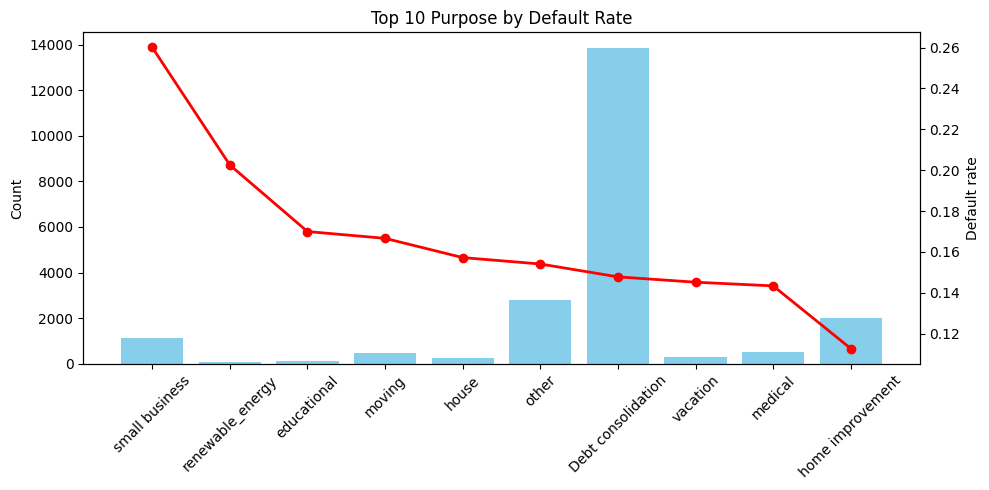

In [84]:
import matplotlib.pyplot as plt

df['is_default'] = df['loan_status'] == 'Charged Off'

summary = df.groupby('purpose').agg(
    total_loans=('is_default', 'size'),
    default_rate=('is_default', 'mean')
).reset_index()


top10 = summary.sort_values('default_rate', ascending=False).head(10)

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(top10['purpose'], top10['total_loans'], color='skyblue')
ax1.set_ylabel('Count')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(top10['purpose'], top10['default_rate'], color='red', marker='o', linewidth=2)
ax2.set_ylabel('Default rate')

plt.title('Top 10 Purpose by Default Rate')
plt.tight_layout()
plt.show()

Small Business loans are the riskiest. Despite the high risk, the volume of these loans remains relatively low.

Debt Consolidation has the highest volume, making it the primary driver of business scale.

Home Improvement is the most safe category. These borrowers are the most creditworthy.

2. GRADE

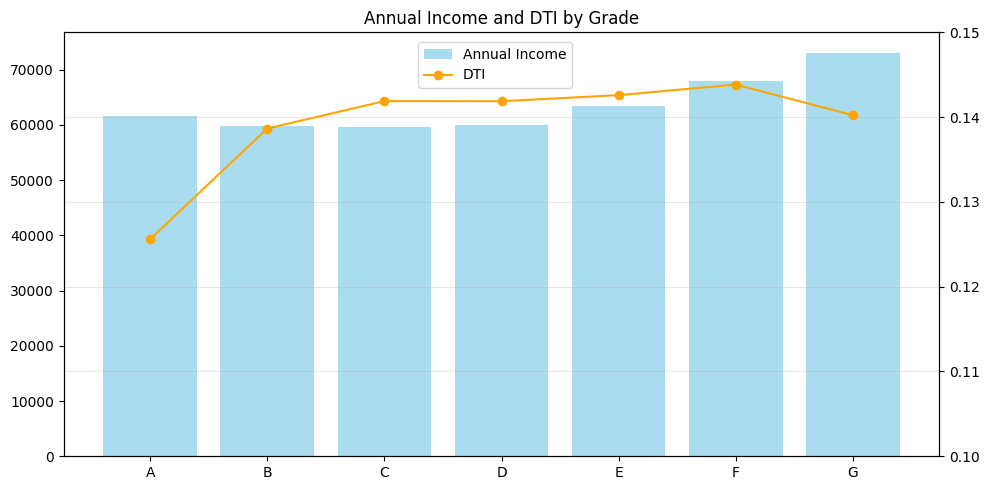

In [77]:
summary = df.groupby('grade')[['annual_income', 'dti']].mean()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(summary.index, summary['annual_income'], color='skyblue', alpha=0.7, label='Annual Income')

ax2 = ax1.twinx()
ax2.plot(summary.index, summary['dti'], color='orange', marker='o', label='DTI')
ax2.set_ylim(0.1, 0.15)

plt.title('Annual Income and DTI by Grade')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

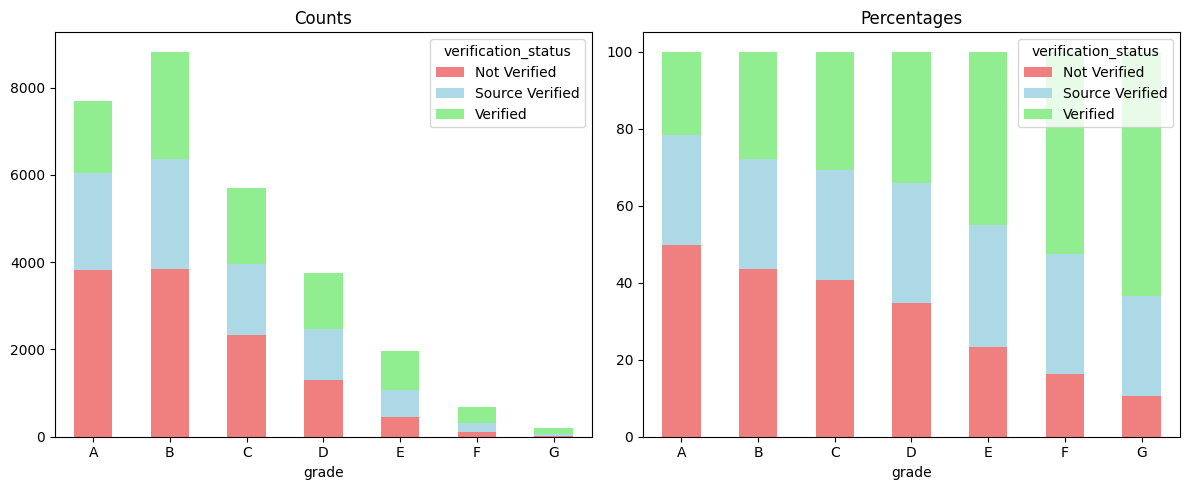

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

count = pd.crosstab(df['grade'], df['verification_status'])
percent = pd.crosstab(df['grade'], df['verification_status'], normalize='index') * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = ['lightcoral', 'lightblue', 'lightgreen']

count.plot.bar(stacked=True, color=colors, ax=ax1)
percent.plot.bar(stacked=True, color=colors, ax=ax2)

ax1.set_title('Counts')
ax2.set_title('Percentages')
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

The lender applies stricter verification to riskier borrowers.

As grades deteriorate from A to G, the proportion of fully Verified loans rises significantly, indicating effective risk-based underwriting.

The small volume in E–G combined with heavy verification suggests cautious exposure to subprime segments.


Bên cho vay áp dụng quy trình xác minh nghiêm ngặt hơn đối với những người vay có rủi ro cao hơn.

Khi xếp hạng tín dụng giảm dần từ A xuống G, tỷ lệ các khoản vay được xác minh đầy đủ tăng lên đáng kể, cho thấy việc thẩm định dựa trên rủi ro rất hiệu quả.

Khối lượng nhỏ các khoản vay ở phân khúc E-G kết hợp với quy trình xác minh nghiêm ngặt cho thấy sự thận trọng trong việc tiếp xúc với phân khúc tín dụng dưới chuẩn.

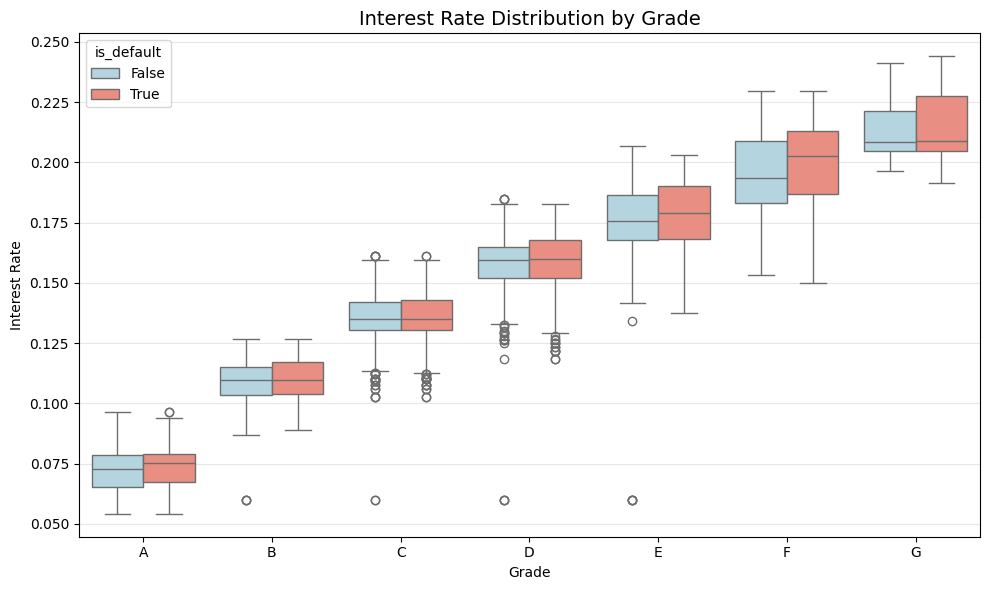

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.boxplot(x='grade', y='int_rate', data=df, hue='is_default', palette={0: 'lightblue', 1: 'salmon'})
plt.title('Interest Rate Distribution by Grade', fontsize=14)
plt.xlabel('Grade')
plt.ylabel('Interest Rate')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

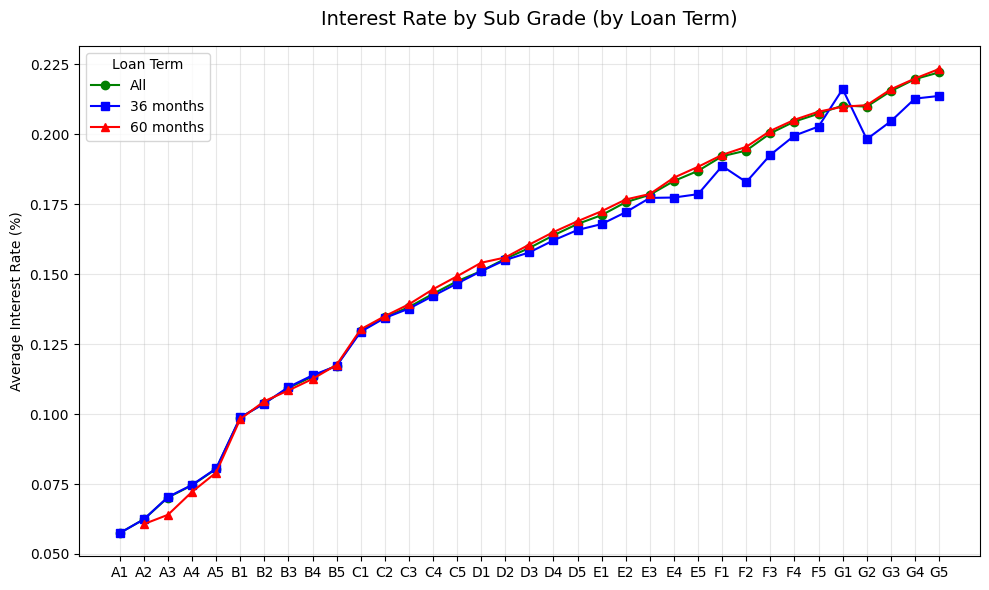

In [80]:
import matplotlib.pyplot as plt

int_sub = df.groupby('sub_grade')['int_rate'].mean()
int_36 = df[df['loan_term'] == 36].groupby('sub_grade')['int_rate'].mean()
int_60 = df[df['loan_term'] == 60].groupby('sub_grade')['int_rate'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(int_sub.index, int_sub.values, marker='o', label='All', color='green')
ax1.plot(int_36.index, int_36.values, marker='s', label='36 months', color='blue')
ax1.plot(int_60.index, int_60.values, marker='^', label='60 months', color='red')

ax1.set_title('Interest Rate by Sub Grade (by Loan Term)', fontsize=14, pad=15)
ax1.set_ylabel('Average Interest Rate (%)')
ax1.legend(title='Loan Term')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

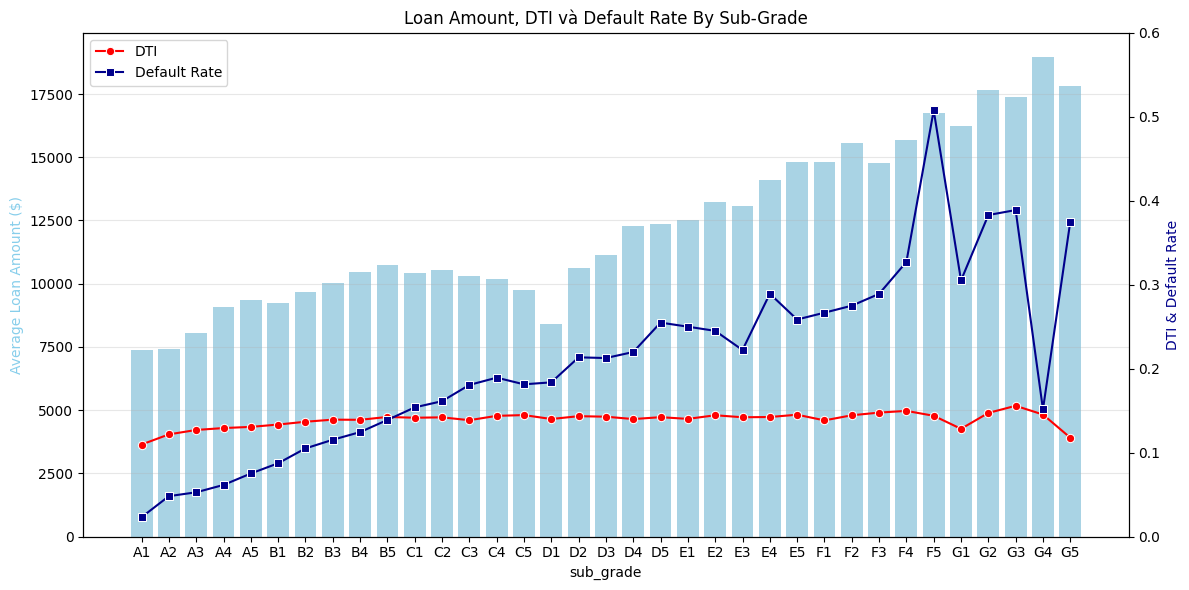

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

summary = df.groupby('sub_grade').agg({
    'loan_amount': 'mean',
    'dti': 'mean',
    'is_default': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=summary, x='sub_grade', y='loan_amount',
            color='skyblue', alpha=0.8, ax=ax1)
ax1.set_ylabel('Average Loan Amount ($)', color='skyblue')

ax2 = ax1.twinx()
sns.lineplot(data=summary, x='sub_grade', y='dti',
             color='red', marker='o', label='DTI', ax=ax2)
sns.lineplot(data=summary, x='sub_grade', y='is_default',
             color='darkblue', marker='s', label='Default Rate', ax=ax2)
ax2.set_ylabel('DTI & Default Rate', color='darkblue')
ax2.set_ylim(0, 0.6)

# Legend gộp + title
ax1.set_title('Loan Amount, DTI và Default Rate By Sub-Grade')
ax1.grid(axis='y', alpha=0.3)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [82]:
# @title Văn bản tiêu đề mặc định

import pandas as pd
import numpy as np

def calculate_rate(loan_term, installment, total_payment, tol=1e-10, max_iter=1000):
    if installment <= total_payment / loan_term:  # Lãi suất <= 0%
        return 0.0

    low = 0.0
    high = 1.0  # Giới hạn rộng (0% đến 1200%/năm mỗi kỳ)

    for _ in range(max_iter):
        mid = (low + high) / 2
        power = (1 + mid) ** loan_term

        if power <= 1:
            installment_calc = total_payment / loan_term
        else:
            installment_calc = total_payment * mid * power / (power - 1)

        if abs(installment_calc - installment) < tol * installment:
            return mid

        if installment_calc < installment:
            low = mid
        else:
            high = mid

    return mid


df['r'] = df.apply(
    lambda row: calculate_rate(row['loan_term'], row['installment'], row['total_payment']),
    axis=1
)

df['r_year_percent'] = round(df['r'] * 12 * 100,2)
print(df[['total_payment', 'installment', 'loan_term', 'r', 'r_year_percent']].head())

   total_payment  installment  loan_term             r  r_year_percent
0           3835       106.53         36  1.127584e-06            0.00
1           3210       148.32         36  3.058663e-02           36.70
2           8686       241.28         36  4.978501e-07            0.00
3           3014        90.48         36  4.257587e-03            5.11
4           8765       243.49         36  3.946814e-06            0.00
